In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import dataset
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
BASE_MODEL_PATH = "test/60_25"

held_in_session_ids = torch.load(os.path.join(BASE_MODEL_PATH, "hisi_nf_1.torch"))
all_session_ids = [m.session_id for m in meta]
held_out_session_ids = set(all_session_ids) - set(held_in_session_ids)

In [2]:
# Okay, so the user can TTA a held in set if they want; we just provide
#  the sets above for our information. The real target here is adapt_session_ids...

adapt_session_ids = ["MonkeyJ_20160426_Session2_S1"]

# This batch size may use up all mem if we have too many sessions, but it's a useful heuristic...
batch_size = 7500 * len(adapt_session_ids)
d, held_out_session_ids = multisession.load_stim_batched(                                                             
    batch_size=batch_size,                                                               
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    held_in_session_ids=adapt_session_ids,
    num_held_out_sessions=0,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [3]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
torch.Size([5000, 20, 77])
Test
torch.Size([2500, 20, 77])


In [16]:
# Make the model. Note that AEs will still be PCA warm-started, and normalizers too.
# Cfg needs to match the original here
# TODO: we probably want to save cfg in the future and just load it...

cfg.training.epochs = 12001
cfg.latent_dim = 85
cfg.tbfm.module.num_bases = 60
cfg.ae.training.lambda_ae_recon = 0.03
cfg.ae.use_two_stage = False
cfg.ae.two_stage.freeze_only_shared = False
cfg.ae.two_stage.lambda_mu = 0.01
cfg.ae.two_stage.lambda_cov = 0.01
cfg.tbfm.training.lambda_fro = 75.0

cfg.meta.is_basis_residual = True
cfg.meta.basis_residual_rank = 16
cfg.meta.training.lambda_l2 = 1e-2

model_path = os.path.join(BASE_MODEL_PATH, "model_nf_1.torch")
ms = multisession.build_from_cfg(cfg, data_train, base_model_path=model_path, device=DEVICE)

# TODO: sample efficiency experiment

Building and fitting normalizers...
Building and warm starting AEs...
Loading base TBFM from file...
BOOM! Dino DNA!


In [19]:
# Let's do a silly validation: load one of the *held in* sessions and use the warm started AE and normalizers.
# This should get okay-ish performance?

# TODO: 2 versions:
#  * PCA warm start and no further AE adaptation
#  * With adaptation after warm start

# TODO: should be warm starting on a tiny support set! Do support set size experiment.

embeddings_stim, results = multisession.test_time_adaptation(
    cfg,
    ms,
    embeddings_rest,
    data_train,
    epochs=12001,
    data_test=data_test,
    ae_warm_start=True,
    adapt_ae=True,
    support_size=300,
)

# Warm start + adaptation, full set, 1000 epochs: 0.3702
# Warm start + adaptation, full set, 500 epochs: 0.4428
# Warm start + adaptation, full set, 300 epochs: 0.4502
# Warm start + adaptation, full set, 250 epochs: 0.4524
# Warm start + adaptation, full set, 200 epochs: 0.4487
# Warm start + adaptation, full set, 100 epochs: 0.4395
# Warm start + adaptation, full set, 20 epochs: 0.3975
# Warm start + adaptation, 300 set, 250 epochs: 0.314423
# Warm start - adaptation, full set, 250 epochs: 0.3965
# Warm start - adaptation, 300 set, 250 epochs: 0.3067
####################### Inner/outer architecture: ######################
# Warm start + adaptation, full set, 12001 epochs: 0.5486
# Warm start + adaptation, full set, 250 epochs: 0.4717
# Warm start - adaptation, 300 set, 12001 epochs: 0.3865

res = []  # TrSS vs tr2
for trss in (300, 500, 1000, 5000):
    embeddings_stim, results = multisession.test_time_adaptation(
        cfg,
        ms,
        embeddings_rest,
        data_train,
        epochs=12001,
        data_test=data_test,
        ae_warm_start=True,
        adapt_ae=True,
        support_size=trss,
    )
    res.append((trss, results['final_test_r2']))

TTA: Training data filtered: 4444/5000 trials kept
TTA: Using 300 samples for adaptation (support set)
TTA: Warm starting autoencoder...
  Warm started AE for MonkeyJ_20160426_Session2_S1
TTA: Meta-learning style AE optimization...
  Running 12001 outer steps, each with 20 inner steps
  Both inner and outer loops use data_for_adaptation (300 samples)
  Outer step 0/12001, loss: 0.666495
  Outer step 1000/12001, loss: 0.357399
  Outer step 2000/12001, loss: 0.339986
  Outer step 3000/12001, loss: 0.324177
  Outer step 4000/12001, loss: 0.319810
  Outer step 5000/12001, loss: 0.312721
  Outer step 6000/12001, loss: 0.309595
  Outer step 7000/12001, loss: 0.305265
  Outer step 8000/12001, loss: 0.303133
  Outer step 9000/12001, loss: 0.299642
  Outer step 10000/12001, loss: 0.301490
  Outer step 11000/12001, loss: 0.299244
  Outer step 12000/12001, loss: 0.299404
0 0.3344588577747345
TTA: Meta-learning optimization complete. Final loss: 0.299404
TTA: Test data filtered: 2310/2500 (92.4%)


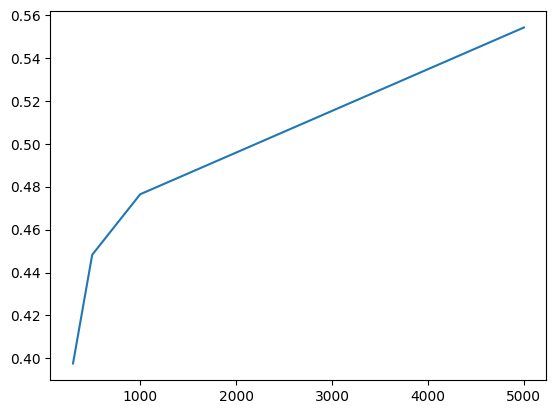

In [21]:
x, y = zip(*res)
plt.plot(x, y)

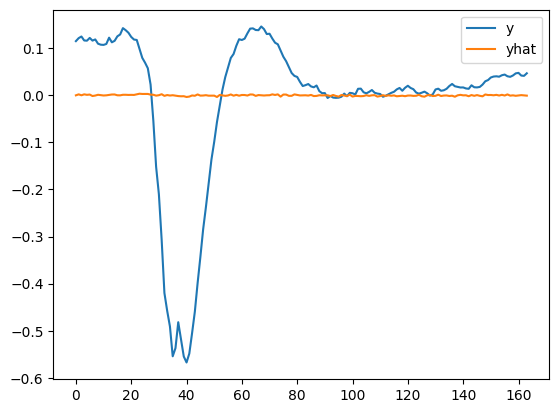

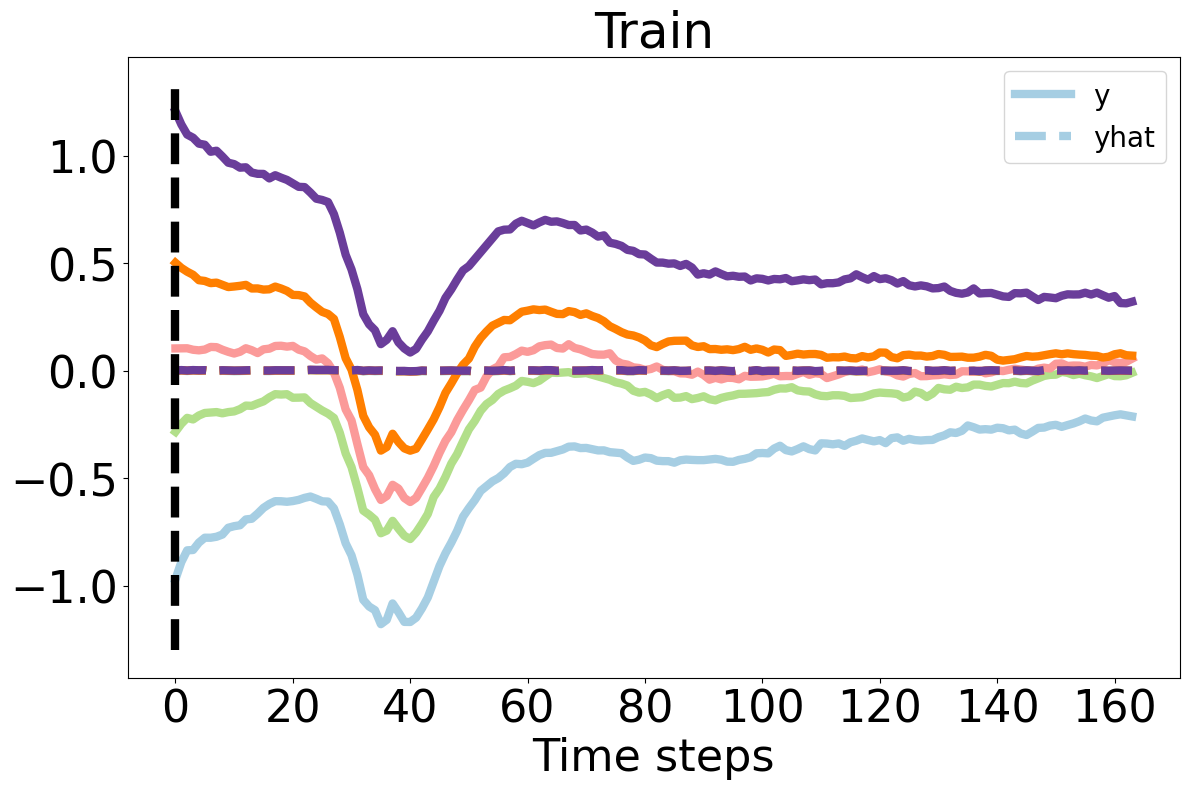

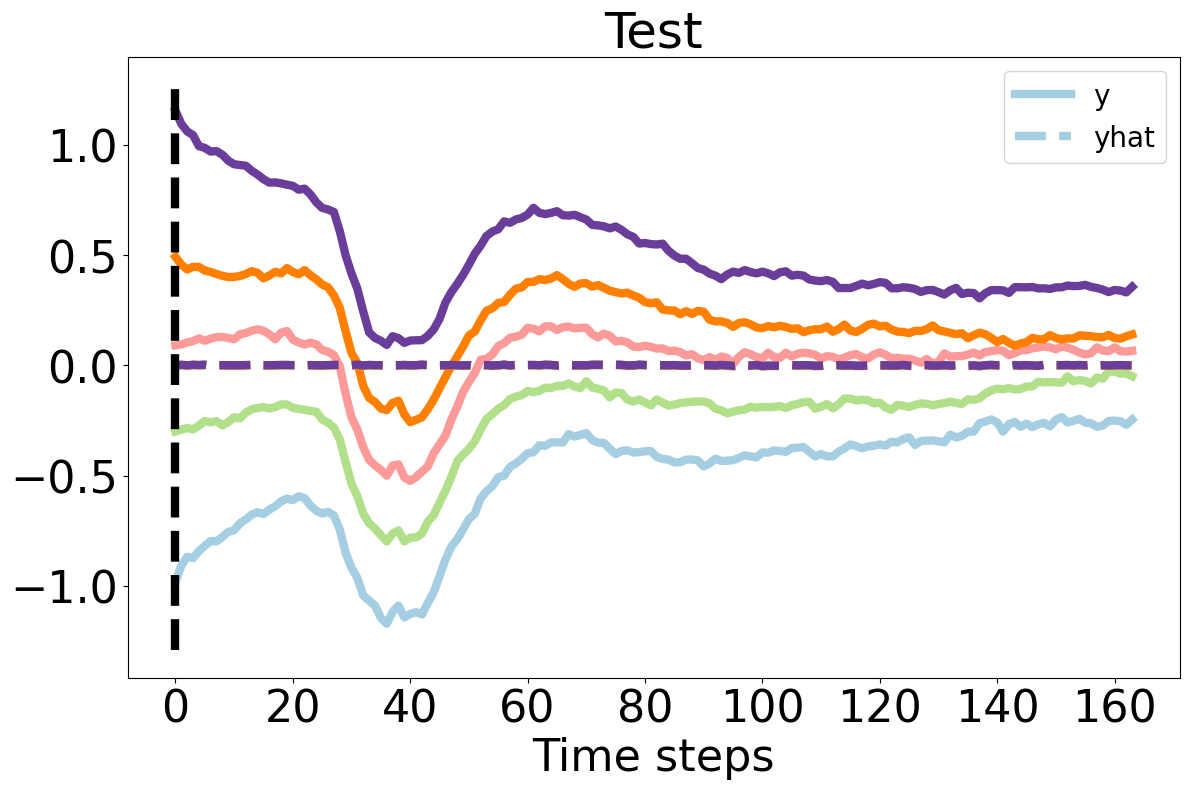

In [11]:
def graph_for_sid(sid, results, data_train, model, embeddings_stim, support_size=300, cidx=30):
    from tbfm import test

    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()

    y = model.norms.instances[sid](results['y'][sid]).detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()

    # model.eval()
    # with torch.no_grad():
    #     dt = {sid: next(iter(data_train))[sid]}
    #     dt = utils.move_batch(dt, device=DEVICE)

        
    #     # Apply outlier filtering to match training behavior
    #     dt, filter_stats = utils.filter_batch_outliers(dt, model.norms, cfg)
    #     if cfg.training.use_outlier_filtering:
    #         print(f"Filtered {filter_stats['per_session'][sid][1] - filter_stats['per_session'][sid][0]} outlier trials")
            
    #     d = dt[sid]
    #     y_norm = model.norms.instances[sid](d[2])
    #     new_d = (d[0][support_size:], d[1][support_size:], y_norm[support_size:])
    #     dt = {sid: new_d}
    #     y_hats2 = model(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)[sid]
        
    # print(y_hats.shape, y_hats_test.shape, y.shape, y_test.shape, y_hats_test2.shape, y_hats2.shape)

    _y = []
    _yhat = []
    # _yhat2 = []
    for bidx in range(y_hats.shape[0]):
        __yhat = y_hats[bidx, :, cidx]
        if __yhat[0] > -1e99: #0.8:
            _y.append(y[bidx, :, cidx].unsqueeze(0))
            _yhat.append(__yhat.unsqueeze(0))
    _y = torch.mean(torch.cat(_y, dim=0), dim=0).detach().cpu()
    _yhat = torch.mean(torch.cat(_yhat, dim=0), dim=0).detach().cpu()
    # _yhat2 = torch.mean(torch.cat(_yhat2, dim=0), dim=0).detach().cpu()
    plt.plot(_y, label="y")
    plt.plot(_yhat, label="yhat")
    # plt.plot(_yhat2, label="yhat2")
    plt.legend()
    plt.show()

    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)


for sid in adapt_session_ids:
    graph_for_sid(sid, results, data_train, ms, embeddings_stim)


In [ ]:
# Then: let's try on a held-out session, but full training set.

In [5]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=20001)

# 15k batch size 3000 0.6836317658424378 0.24544973075389862
# 10k batch size 3000 0.6723785549402237 0.24294960126280785
# 7.5k batch size 3000 0.6306539237499237 0.34320169389247895
# 5k batch size 

# 7.5k no ae coadapt: 

---- 0 1.8234667778015137 1.486933708190918 -0.8891817132631937 -0.5328980684280396
---- 1000 0.5899742841720581 0.5507943630218506 0.3826422741015752 0.43499526381492615
---- 2000 0.581556499004364 0.549232006072998 0.39112886786460876 0.43645283579826355
---- 3000 0.578947901725769 0.5422236323356628 0.3938383956750234 0.44358503818511963
---- 4000 0.5930135250091553 0.5486187934875488 0.3809671103954315 0.43679529428482056
---- 5000 0.572654664516449 0.535224437713623 0.40044142802556354 0.4508146643638611
---- 6000 0.5688191652297974 0.5323787927627563 0.40421965221563977 0.45374569296836853
---- 7000 0.5617053508758545 0.532183051109314 0.41133420666058856 0.45391416549682617
---- 8000 0.5615584850311279 0.5309649705886841 0.4116242031256358 0.455045223236084
---- 9000 0.5558925867080688 0.5284721255302429 0.41714655856291455 0.4577196538448334
---- 10000 0.5591580271720886 0.5314217805862427 0.4140358219544093 0.45462727546691895
---- 11000 0.554527223110199 0.5307040214538574 0.